In [82]:
import os
import numpy as np
import argparse
import itertools
import torch
from torchvision.transforms import InterpolationMode
import pickle

from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

from utils import read_results, write_results

In [102]:
# take in 3 dicts, and fgsm_pgd cols and cw cols
def dicts_to_df(fgsm, pgd, cw, fgsm_pgd_cols, cw_cols, individual=False):
    # convert to df
    fgsm_df = pd.DataFrame.from_dict(fgsm, orient='index', columns=fgsm_pgd_cols)
    pgd_df = pd.DataFrame.from_dict(pgd, orient='index', columns=fgsm_pgd_cols)
    cw_df = pd.DataFrame.from_dict(cw, orient='index', columns=cw_cols)

    if not individual:
        df = pd.concat([fgsm_df, pgd_df, cw_df], ignore_index=True)
        df = df.sort_index()
        df = df.sort_values(by=['dataset', 'attack_type', 'epsilon']).reset_index(drop=True)

        return df
    else:
        return fgsm_df, pgd_df, cw_df

In [103]:
# read advens results
fgsm, pgd, cw = {}, {}, {}
folder = "attack_results"
for fp in os.listdir(folder):
    if 'advens' in fp:
        results = read_results(os.path.join(folder, fp))
        if "fgsm" in fp:
            fgsm.update(results)
        elif "pgd" in fp:
            pgd.update(results)
        elif "cw" in fp:
            cw.update(results)
print(len(fgsm), len(pgd), len(cw))

# dict to pandas
fgsm_pgd_cols = [x.strip() for x in """
    attack_type, dataset, epsilon, nb_iter, eps_iter, rand_init,
    test_acc, norm
""".split(",")]
cw_cols = [x.strip() for x in """
    attack_type, dataset, epsilon, initial_const,
    test_acc, norm
""".split(",")]

advens_df = dicts_to_df(fgsm, pgd, cw, fgsm_pgd_cols, cw_cols)


#  read fastadv results
fgsm, pgd, cw = {}, {}, {}
for fp in os.listdir(folder):
    if 'fastadv' in fp:
        results = read_results(os.path.join(folder, fp))
        if "fgsm" in fp:
            fgsm.update(results)
        elif "pgd" in fp:
            pgd.update(results)
        elif "cw" in fp:
            cw.update(results)
print(len(fgsm), len(pgd), len(cw))

fastadv_df = dicts_to_df(fgsm, pgd, cw, fgsm_pgd_cols, cw_cols)

4 4 4
4 4 4


In [108]:
# read ensemble results
fgsm, pgd, cw = {}, {}, {}
for fp in os.listdir("attack_results"):
    if 'advens' not in fp and 'denoiser' not in fp:
        results = read_results(os.path.join("attack_results", fp))
        if "fgsm" in fp:
            fgsm.update(results)
        elif "pgd" in fp:
            pgd.update(results)
        elif "cw" in fp:
            cw.update(results)
print(len(fgsm), len(pgd), len(cw))

# read denoiser results
d_fgsm, d_pgd, d_cw = {}, {}, {}
for fp in os.listdir("attack_results"):
    if 'denoiser' in fp:
        results = read_results(os.path.join("attack_results", fp))
        if "fgsm" in fp:
            d_fgsm.update(results)
        elif "pgd" in fp:
            d_pgd.update(results)
        elif "cw" in fp:
            d_cw.update(results)
print(len(d_fgsm), len(d_pgd), len(d_cw))

# dict to pandas
fgsm_pgd_cols = [x.strip() for x in """
    attack_type, dataset, scaling_factor, up_samplers, down_samplers, 
    interpolation, epsilon, nb_iter, eps_iter, rand_init, initial_const, 
    voting_method, test_acc, norm
""".split(",")]
cw_cols = [x.strip() for x in """
    attack_type, dataset, scaling_factor, up_samplers, down_samplers,
    interpolation, epsilon, initial_const,
    voting_method, test_acc, norm
""".split(",")]

fgsm_df, pgd_df, cw_df = dicts_to_df(fgsm, pgd, cw, fgsm_pgd_cols, cw_cols, individual=True)

denoise_df = dicts_to_df(d_fgsm, d_pgd, d_cw, fgsm_pgd_cols, cw_cols, individual=False)

len(denoise_df)

3038 936 132
608 160 112


880

In [109]:
# Extract pgd attacks from fgsm_df and add to pgd_df
pgd_extras = fgsm_df[fgsm_df['rand_init'] == True]
pgd_df = pd.concat([pgd_df, pgd_extras])
pgd_df['attack_type'] = 'pgd'

# Remove these from fgsm_df
fgsm_df = fgsm_df[fgsm_df['rand_init'] == False]

In [110]:
# drop duplicates
cols = set(denoise_df.columns)
cols.remove('test_acc')

cw_cols = set(cw_df.columns)
cw_cols.remove('test_acc')

denoise_df = denoise_df.drop_duplicates(subset=cols)

pgd_df = pgd_df.drop_duplicates(subset=cols)
fgsm_df = fgsm_df.drop_duplicates(subset=cols)
cw_df = cw_df.drop_duplicates(subset=cw_cols)

print(len(fgsm_df), len(pgd_df), len(cw_df), len(denoise_df))

2648 808 132 880


In [111]:
# Set all attack types
fgsm_df['attack_type'] = 'fgsm'
pgd_df['attack_type'] = 'pgd'
cw_df['attack_type'] = 'cw'
# Set denoiser
fgsm_df['denoiser'] = False
pgd_df['denoiser'] = False
cw_df['denoiser'] = False
denoise_df['denoiser'] = True

In [112]:
# fgsm filters (remove results from previous runs which are no longer considered)
norms = [np.inf]
epsilons = [x/256 for x in [2, 5, 10, 16]]
interpolations = ["bilinear"]
scalings = [2.0, 1.1]
scaling_2_up_down = [
    *[(0, i) for i in range(0, 4)],
    *[(i, 0) for i in range(1, 4)],
    *[(i, i) for i in [0, 1, 2, 3]]
]
scaling_11_up_down = [
    *[(0, i) for i in [3, 5, 7]],
    *[(i, 0) for i in [3, 5, 7]],
    *[(i, i) for i in [5, 7]],
]
rand_inits = [False]

# apply filters
fgsm_filt = fgsm_df[fgsm_df['norm'].isin(norms)]
fgsm_filt = fgsm_filt[fgsm_filt['epsilon'].isin(epsilons)]
fgsm_filt = fgsm_filt[fgsm_filt['interpolation'].isin(interpolations)]
fgsm_filt = fgsm_filt[fgsm_filt['scaling_factor'].isin(scalings)]
tmp_2 = fgsm_filt[fgsm_filt['scaling_factor'] == 2.0]
tmp_11 = fgsm_filt[fgsm_filt['scaling_factor'] == 1.1]
fgsm_filt = pd.concat([
    tmp_2[tmp_2['up_samplers'].isin([x[0] for x in scaling_2_up_down]) & \
        tmp_2['down_samplers'].isin([x[1] for x in scaling_2_up_down])],
    tmp_11[tmp_11['up_samplers'].isin([x[0] for x in scaling_11_up_down]) & \
        tmp_11['down_samplers'].isin([x[1] for x in scaling_11_up_down])]])
fgsm_filt = fgsm_filt[fgsm_filt['rand_init'].isin(rand_inits)]

len(fgsm_df), len(fgsm_filt)

(2648, 608)

In [113]:
# pgd filters
norms = [np.inf]
nb_iters = [40]
eps_iters = [5e-4]
rand_inits = [True]
epsilons = [x/256 for x in [2, 5, 10, 16]]
interpolations = ["bilinear"]
scalings = [2.0, 1.1]
scaling_2_up_down = [
    *[(i, i) for i in [0, 3]]
]
scaling_11_up_down = [
    *[(i, i) for i in [5, 7]],
]

# apply filters
pgd_filt = pgd_df[pgd_df['norm'].isin(norms)]
pgd_filt = pgd_filt[pgd_filt['nb_iter'].isin(nb_iters)]
pgd_filt = pgd_filt[pgd_filt['eps_iter'].isin(eps_iters)]
pgd_filt = pgd_filt[pgd_filt['rand_init'].isin(rand_inits)]
pgd_filt = pgd_filt[pgd_filt['epsilon'].isin(epsilons)]
pgd_filt = pgd_filt[pgd_filt['interpolation'].isin(interpolations)]
pgd_filt = pgd_filt[pgd_filt['scaling_factor'].isin(scalings)]
tmp_2 = pgd_filt[pgd_filt['scaling_factor'] == 2.0]
tmp_11 = pgd_filt[pgd_filt['scaling_factor'] == 1.1]
pgd_filt = pd.concat([
    tmp_2[tmp_2['up_samplers'].isin([x[0] for x in scaling_2_up_down]) & \
    tmp_2['down_samplers'].isin([x[1] for x in scaling_2_up_down])],
    tmp_11[tmp_11['up_samplers'].isin([x[0] for x in scaling_11_up_down]) & \
    tmp_11['down_samplers'].isin([x[1] for x in scaling_11_up_down])]
])

len(pgd_df), len(pgd_filt)

(808, 160)

In [114]:
# cw filters
norms = [2.0]
epsilons = [0.5, 1.0, 2.0, 3.5]
interpolations = ["bilinear"]
scalings = [2.0, 1.1]
scaling_2_up_down = [
    *[(i, i) for i in [0, 3]]
]
scaling_11_up_down = [
    *[(i, i) for i in [5, 7]],
]

# apply filters
cw_filt = cw_df[cw_df['norm'].isin(norms)]
cw_filt = cw_filt[cw_filt['epsilon'].isin(epsilons)]
cw_filt = cw_filt[cw_filt['interpolation'].isin(interpolations)]
cw_filt = cw_filt[cw_filt['scaling_factor'].isin(scalings)]
tmp_2 = cw_filt[cw_filt['scaling_factor'] == 2.0]
tmp_11 = cw_filt[cw_filt['scaling_factor'] == 1.1]
cw_filt = pd.concat([
    tmp_2[tmp_2['up_samplers'].isin([x[0] for x in scaling_2_up_down]) & \
    tmp_2['down_samplers'].isin([x[1] for x in scaling_2_up_down])],
    tmp_11[tmp_11['up_samplers'].isin([x[0] for x in scaling_11_up_down]) & \
    tmp_11['down_samplers'].isin([x[1] for x in scaling_11_up_down])]
])

len(cw_df), len(cw_filt)

(132, 128)

In [115]:
# combine dfs
df = pd.concat([fgsm_filt, pgd_filt, cw_filt]).reset_index(drop=True)
df

/tmp/ipykernel_183124/1751330270.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([fgsm_filt, pgd_filt, cw_filt]).reset_index(drop=True)


,attack_type,dataset,scaling_factor,up_samplers,down_samplers,interpolation,epsilon,nb_iter,eps_iter,rand_init,initial_const,voting_method,test_acc,norm,denoiser
0,fgsm,cifar10,2.0,0.0,0.0,bilinear,0.019531,10.0,0.01,False,0.1,simple_avg,0.2250,inf,False
1,fgsm,cifar10,2.0,0.0,0.0,bilinear,0.039062,10.0,0.01,False,0.1,simple_avg,0.1489,inf,False
2,fgsm,cifar10,2.0,0.0,0.0,bilinear,0.0625,10.0,0.01,False,0.1,simple_avg,0.1266,inf,False
3,fgsm,cifar10,2.0,0.0,0.0,bilinear,0.019531,10.0,0.01,False,0.1,weighted_avg,0.2250,inf,False
4,fgsm,cifar10,2.0,0.0,0.0,bilinear,0.039062,10.0,0.01,False,0.1,weighted_avg,0.1489,inf,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,cw,cifar10,1.1,7.0,7.0,bilinear,1.0,NaN,NaN,NaN,0.0,weighted_vote,0.5500,2.0,False
892,cw,cifar10,1.1,7.0,7.0,bilinear,2.0,NaN,NaN,NaN,0.0,weighted_avg,0.1120,2.0,False
893,cw,cifar10,1.1,7.0,7.0,bilinear,2.0,NaN,NaN,NaN,0.0,weighted_vote,0.5160,2.0,False
894,cw,cifar10,1.1,7.0,7.0,bilinear,3.5,NaN,NaN,NaN,0.0,weighted_avg,0.1120,2.0,False


In [116]:
# drop cols that are the same for all rows
def drop_redundant_cols(df):
    drop_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            drop_cols.append(col)
    df = df.drop(columns=drop_cols)
    return df

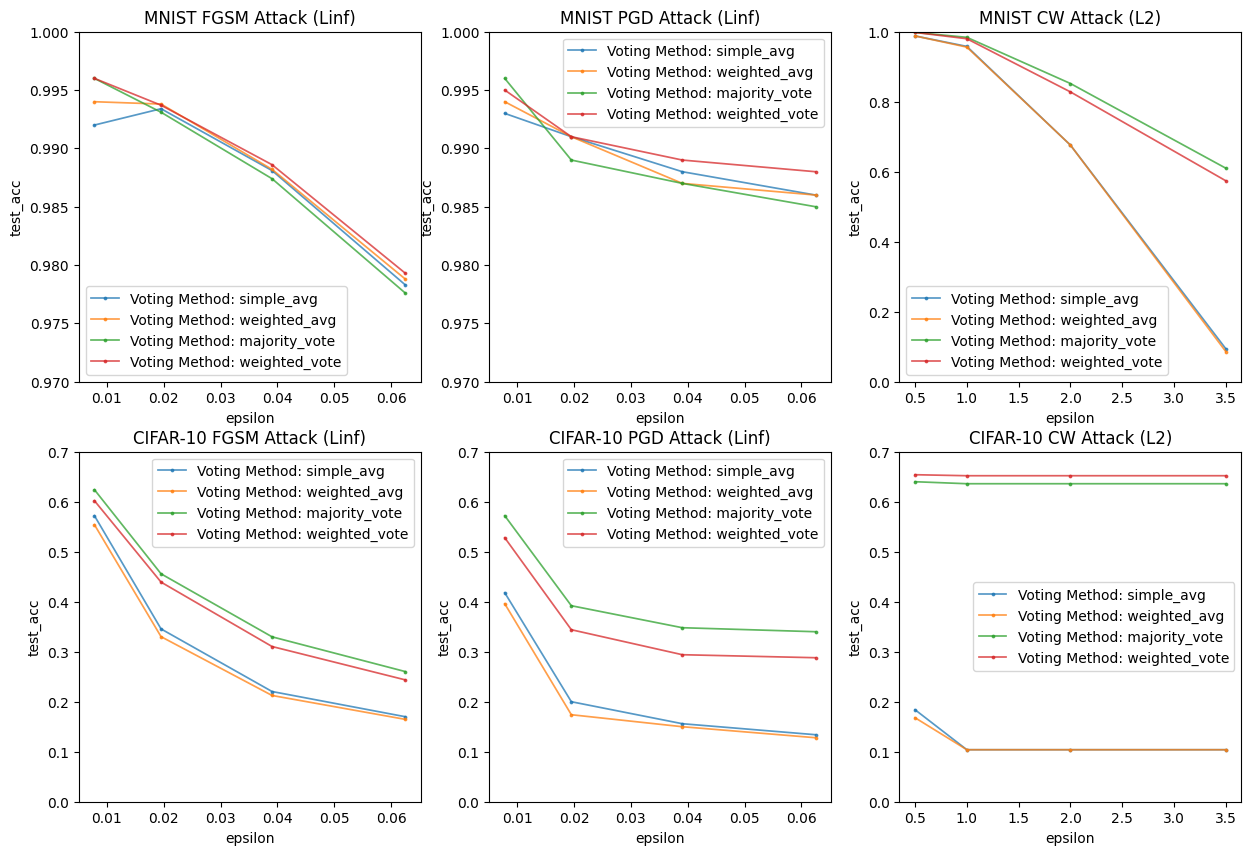

In [117]:
# comparison between voting methods
# filter to (scaling, up_samplers, down_samplers) = (2.0, 3, 3), (np.inf, 7, 7)
df['voting_method'] = pd.Categorical(df['voting_method'], ["simple_avg", "weighted_avg", "majority_vote", "weighted_vote"])

df_filt = df[
    ((df['scaling_factor'] == 2.0) & (df['up_samplers'] == 3) & (df['down_samplers'] == 3)) | \
    ((df['scaling_factor'] == np.inf) & (df['up_samplers'] == 7) & (df['down_samplers'] == 7))
]
# filter by dataset and attack type
plot_data = {}
for dataset in ['mnist', 'cifar10']:
    for attack_type in ['fgsm', 'pgd', 'cw']:
        df_attack = df_filt[
            (df_filt['dataset'] == dataset) & \
            (df_filt['attack_type'] == attack_type)
        ]
        df_attack = df_attack.sort_values(by=['voting_method', 'epsilon'])
        df_attack = drop_redundant_cols(df_attack)

        # create arrays of test_acc and epsilon for each voting method
        plot_data[f'{dataset}_{attack_type}'] = {}
        for i in range(len(df_attack)):
            row = df_attack.iloc[i]
            name = f'Voting Method: {row["voting_method"]}'
            if name not in plot_data[f'{dataset}_{attack_type}']:
                plot_data[f'{dataset}_{attack_type}'][name] = [[], []]
            plot_data[f'{dataset}_{attack_type}'][name][0].append(row['test_acc'])
            plot_data[f'{dataset}_{attack_type}'][name][1].append(row['epsilon'])

# plot
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].set_title('MNIST FGSM Attack (Linf)')
ax[0, 1].set_title('MNIST PGD Attack (Linf)')
ax[0, 2].set_title('MNIST CW Attack (L2)')
ax[1, 0].set_title('CIFAR-10 FGSM Attack (Linf)')
ax[1, 1].set_title('CIFAR-10 PGD Attack (Linf)')
ax[1, 2].set_title('CIFAR-10 CW Attack (L2)')
for i in range(2):
    for j in range(3):
        ax[i, j].set_xlabel('epsilon')
        ax[i, j].set_ylabel('test_acc')
# plot test_acc vs epsilon for each voting method
y_ranges = [(0.97, 1.0), (0.0, 0.7)]
for i in range(2):
    for j in range(3):
        for name, data in plot_data[f'{["mnist", "cifar10"][i]}_{["fgsm", "pgd", "cw"][j]}'].items():
            ax[i, j].plot(data[1], data[0], label=name, marker='o',
                linewidth=1.25, markersize=1.75, alpha=0.75)
        ax[i, j].legend()
        if i == 0 and j == 2:
            ax[i, j].set_ylim(0.0, 1.0)
        else:
            ax[i, j].set_ylim(y_ranges[i])

plt.savefig('graphs/voting_methods.png', dpi=100, bbox_inches='tight', pad_inches=0.05)
plt.show()

In [118]:
colors = """
#000000

#00c1ff
#007cff
#1c00d1

#ff87bc
#ff486d
#e60000
"""
colors = [x.strip() for x in colors.split('\n') if x.strip() != '']

color_map = {}
for i, k in enumerate(mnist_plot_data.keys()):
    color_map[k] = colors[i]
print(color_map)

{'Up: 0.0, Down: 0.0': '#000000', 'Up: 0.0, Down: 1.0': '#00c1ff', 'Up: 0.0, Down: 2.0': '#007cff', 'Up: 0.0, Down: 3.0': '#1c00d1', 'Up: 1.0, Down: 0.0': '#ff87bc', 'Up: 2.0, Down: 0.0': '#ff486d', 'Up: 3.0, Down: 0.0': '#e60000'}


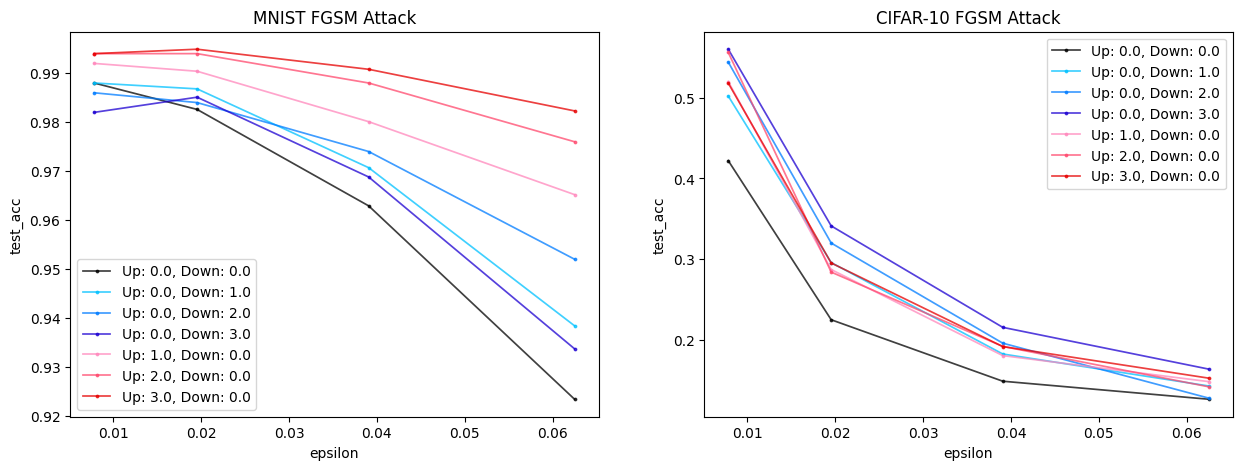

In [119]:
# Analyze difference between up and down samplers

# filter to mnist, scaling 2.0, fgsm
df_filt = df[ 
    (df['scaling_factor'] == 2.0) & \
    (df['attack_type'] == 'fgsm') & \
    (df['voting_method'] == 'weighted_avg')
]

# drop rows without a zero in either up_samplers or down_samplers
df_filt = df_filt[(df_filt['up_samplers'] == 0) | (df_filt['down_samplers'] == 0)]
# sort by up_samplers and down_samplers
df_filt = df_filt.sort_values(by=['dataset', 'up_samplers', 'down_samplers', 'epsilon']).reset_index(drop=True)

# split by dataset
mnist_filt = df_filt[df_filt['dataset'] == 'mnist']
cifar_filt = df_filt[df_filt['dataset'] == 'cifar10']

# drop cols
mnist_filt = drop_redundant_cols(mnist_filt)
cifar_filt = drop_redundant_cols(cifar_filt)

# create arrays of test_acc and epsilon for each up down pair
mnist_plot_data = {}
for i in range(len(mnist_filt)):
    row = mnist_filt.iloc[i]
    name = f'Up: {row["up_samplers"]}, Down: {row["down_samplers"]}'
    if name not in mnist_plot_data:
        mnist_plot_data[name] = [[], []]
    mnist_plot_data[name][0].append(row['test_acc'])
    mnist_plot_data[name][1].append(row['epsilon'])

cifar_plot_data = {}
for i in range(len(cifar_filt)):
    row = cifar_filt.iloc[i]
    name = f'Up: {row["up_samplers"]}, Down: {row["down_samplers"]}'
    if name not in cifar_plot_data:
        cifar_plot_data[name] = [[], []]
    cifar_plot_data[name][0].append(row['test_acc'])
    cifar_plot_data[name][1].append(row['epsilon'])

# plot
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('MNIST FGSM Attack')
ax[1].set_title('CIFAR-10 FGSM Attack')
ax[0].set_xlabel('epsilon')
ax[1].set_xlabel('epsilon')
ax[0].set_ylabel('test_acc')
ax[1].set_ylabel('test_acc')
# plot test_acc vs epsilon for each up_samplers and down_samplers
for name, data in mnist_plot_data.items():
    ax[0].plot(data[1], data[0], label=name, marker='o',
                linewidth=1.25, markersize=1.75, alpha=0.75, 
                color=color_map[name])
for name, data in cifar_plot_data.items():
    ax[1].plot(data[1], data[0], label=name, marker='o',
                linewidth=1.25, markersize=1.75, alpha=0.75,
                color=color_map[name])
ax[0].legend()
ax[1].legend()
plt.savefig('graphs/up_down_samplers.png', dpi=100, bbox_inches='tight', pad_inches=0.05)
plt.show()

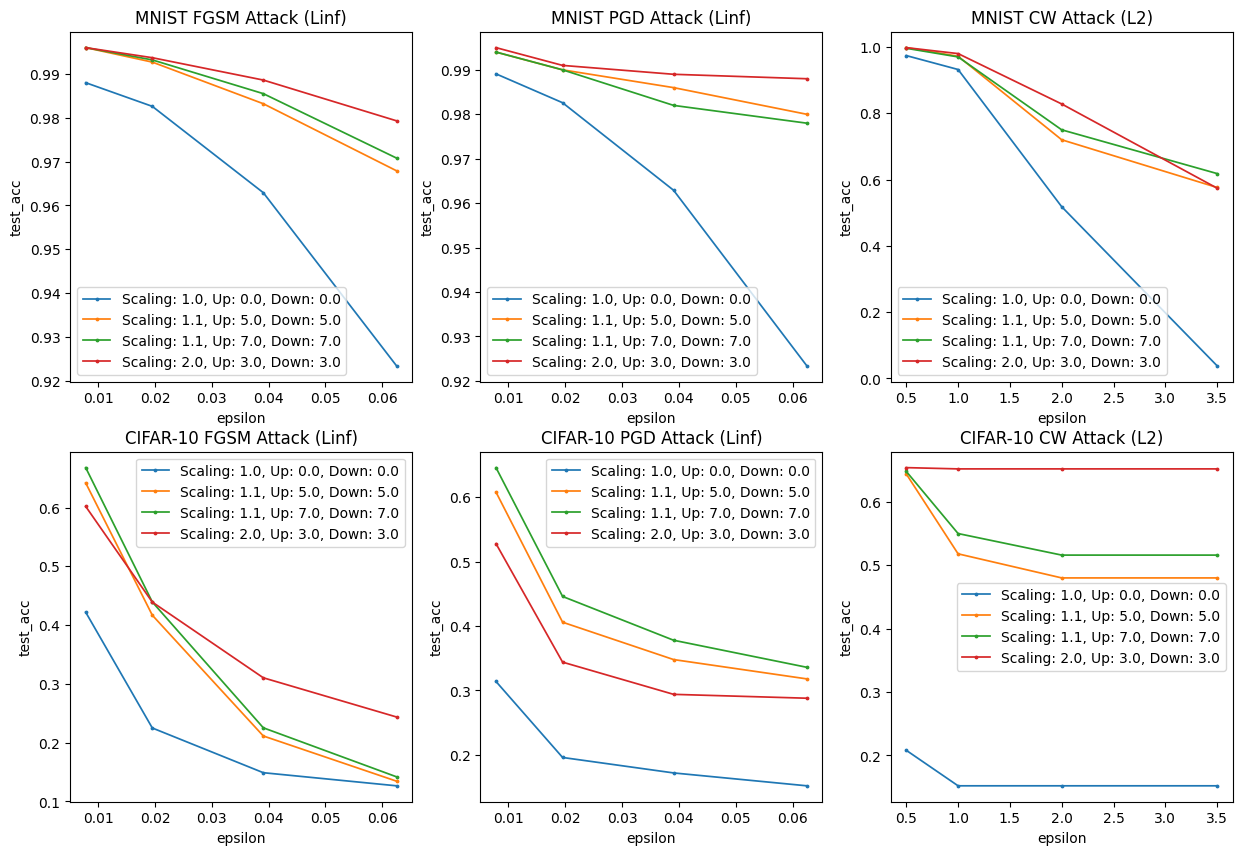

In [120]:
# compare 1.1 and 2.0 scaling
# filter to (up_samplers, down_samplers) = (0, 0), (3, 3), (5, 5), (7, 7)
df_filt = df[
    ((df['up_samplers'] == 0) & (df['down_samplers'] == 0)) | \
    ((df['up_samplers'] == 3) & (df['down_samplers'] == 3) & (df['scaling_factor'] == 2.0)) | \
    ((df['up_samplers'] == 5) & (df['down_samplers'] == 5)) | \
    ((df['up_samplers'] == 7) & (df['down_samplers'] == 7))
]
# filter to weighted_vote
df_filt = df_filt[df_filt['voting_method'] == 'weighted_vote']

# set (0, 0) to 1.0 scaling
df_filt.loc[(df_filt['up_samplers'] == 0) & (df_filt['down_samplers'] == 0), 'scaling_factor'] = 1.0

# filter by dataset and attack type
plot_data = {}
for dataset in ['mnist', 'cifar10']:
    for attack_type in ['fgsm', 'pgd', 'cw']:
        df_attack = df_filt[
            (df_filt['dataset'] == dataset) & \
            (df_filt['attack_type'] == attack_type)
        ]
        df_attack = df_attack.sort_values(by=['scaling_factor','up_samplers', 'down_samplers', 'epsilon'])
        df_attack = drop_redundant_cols(df_attack)
        

        # create arrays of test_acc and epsilon for each scaling factor
        plot_data[f'{dataset}_{attack_type}'] = {}
        for i in range(len(df_attack)):
            row = df_attack.iloc[i]
            name = f'Scaling: {row["scaling_factor"]}, Up: {row["up_samplers"]}, Down: {row["down_samplers"]}'
            if name not in plot_data[f'{dataset}_{attack_type}']:
                plot_data[f'{dataset}_{attack_type}'][name] = [[], []]
            plot_data[f'{dataset}_{attack_type}'][name][0].append(row['test_acc'])
            plot_data[f'{dataset}_{attack_type}'][name][1].append(row['epsilon'])

# plot
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].set_title('MNIST FGSM Attack (Linf)')
ax[0, 1].set_title('MNIST PGD Attack (Linf)')
ax[0, 2].set_title('MNIST CW Attack (L2)')
ax[1, 0].set_title('CIFAR-10 FGSM Attack (Linf)')
ax[1, 1].set_title('CIFAR-10 PGD Attack (Linf)')
ax[1, 2].set_title('CIFAR-10 CW Attack (L2)')
for i in range(2):
    for j in range(3):
        ax[i, j].set_xlabel('epsilon')
        ax[i, j].set_ylabel('test_acc')
# plot test_acc vs epsilon for each scaling factor
for i in range(2):
    for j in range(3):
        for name, data in plot_data[f'{["mnist", "cifar10"][i]}_{["fgsm", "pgd", "cw"][j]}'].items():
            ax[i, j].plot(data[1], data[0], label=name, marker='o',
                linewidth=1.25, markersize=1.75)
        ax[i, j].legend()
plt.savefig('graphs/scaling_factor.png', dpi=100, bbox_inches='tight', pad_inches=0.05)
plt.show()

In [124]:
# comparison with adversarial ensemble training and fast adversarial training
# filter to (scaling, up_samplers, down_samplers) = (2.0, 3, 3), (1.1, 7, 7)

df_filt = pd.concat([df, denoise_df])

df_filt = df_filt[
    ((df_filt['scaling_factor'] == 2.0) & (df_filt['up_samplers'] == 3) & (df_filt['down_samplers'] == 3)) | \
    ((df_filt['scaling_factor'] == 1.1) & (df_filt['up_samplers'] == 7) & (df_filt['down_samplers'] == 7))
]
# filter to cifar10 and weighted_vote
df_filt = df_filt[
    (df_filt['dataset'] == 'cifar10') & \
    (df_filt['voting_method'] == 'weighted_vote')
]
df_filt = drop_redundant_cols(df_filt)

# Add ensemble adversarial training data
advens_filt = drop_redundant_cols(advens_df)
advens_filt['attack_type'] = 'advens_' + advens_filt['attack_type']

# Add fast adversarial training data
fastadv_filt = drop_redundant_cols(fastadv_df)
fastadv_filt['attack_type'] = 'fastadv_' + fastadv_filt['attack_type']

df_filt = pd.concat([advens_filt, fastadv_filt, df_filt])

# drop nb_iter, eps_iter, rand_init, initial_const, norm
df_filt = df_filt.drop(columns=['nb_iter', 'eps_iter', 'rand_init', 'initial_const', 'norm', 'up_samplers', 'down_samplers'])

# add in initial accuracies for eps=0
fastadv_acc = 0.844
advens_acc = 0.83
acc_20 = 0.804
acc_11 = 0.794

# filter by attack type
plot_data = {}
for attack_type in ['fgsm', 'pgd', 'cw']:
    df_attack = df_filt[
        (df_filt['attack_type'] == attack_type) | \
        (df_filt['attack_type'] == f'advens_{attack_type}') | \
        (df_filt['attack_type'] == f'fastadv_{attack_type}')
    ]
    df_attack = df_attack.sort_values(by=['attack_type','scaling_factor','epsilon'])
    df_attack = drop_redundant_cols(df_attack)

    # create arrays of test_acc and epsilon for each attack_type and voting method
    plot_data[f'{attack_type}'] = {}
    for i in range(len(df_attack)):
        row = df_attack.iloc[i]
        if row['attack_type'] == f'advens_{attack_type}':
            name = 'AdvEns'
        elif row['attack_type'] == f'fastadv_{attack_type}':
            name = 'FastAdv'
        else:
            name = f'{"denoiser" if row["denoiser"] else "no denoiser"}, Scaling: {row["scaling_factor"]}'
        if name not in plot_data[f'{attack_type}']:
            if name == 'AdvEns':
                plot_data[f'{attack_type}'][name] = [[advens_acc], [0]]
            elif name == 'FastAdv':
                plot_data[f'{attack_type}'][name] = [[fastadv_acc], [0]]
            elif row['scaling_factor'] == 2.0:
                plot_data[f'{attack_type}'][name] = [[acc_20], [0]]
            else:
                plot_data[f'{attack_type}'][name] = [[acc_11], [0]]
        plot_data[f'{attack_type}'][name][0].append(row['test_acc'])
        plot_data[f'{attack_type}'][name][1].append(row['epsilon'])


# plot
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].set_title('CIFAR-10 FGSM Attack (Linf)')
ax[1].set_title('CIFAR-10 PGD Attack (Linf)')
ax[2].set_title('CIFAR-10 CW Attack (L2)')
for i in range(3):
    ax[i].set_xlabel('epsilon')
    ax[i].set_ylabel('test_acc')
# plot test_acc vs epsilon for each scaling factor
keys = plot_data[f'fgsm'].keys()
for i, attack_type in enumerate(['fgsm', 'pgd', 'cw']):
    for k in keys:
        name, data = k, plot_data[attack_type][k]
        ax[i].plot(data[1], data[0], label=name, marker='o',
            linewidth=1.25, markersize=1.75, alpha=0.7)
    ax[i].legend()
plt.savefig('graphs/comparison.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.tight_layout()
plt.show()

/tmp/ipykernel_183124/3358024966.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filt = df_filt[


NameError: name 'a' is not defined

In [129]:
df_filt = pd.concat([df, denoise_df])

df_filt = df_filt[
    ((df_filt['scaling_factor'] == 2.0) & (df_filt['up_samplers'] == 3) & (df_filt['down_samplers'] == 3)) | \
    ((df_filt['scaling_factor'] == 1.1) & (df_filt['up_samplers'] == 7) & (df_filt['down_samplers'] == 7))
]
# filter to cifar10 and weighted_vote
df_filt = df_filt[
    (df_filt['dataset'] == 'cifar10') & \
    (df_filt['voting_method'] == 'weighted_vote')
]
df_filt = drop_redundant_cols(df_filt)

# Add ensemble adversarial training data
advens_filt = drop_redundant_cols(advens_df)
advens_filt['attack_type'] = 'advens_' + advens_filt['attack_type']

# Add fast adversarial training data
fastadv_filt = drop_redundant_cols(fastadv_df)
fastadv_filt['attack_type'] = 'fastadv_' + fastadv_filt['attack_type']

df_filt = pd.concat([advens_filt, fastadv_filt, df_filt])

# drop nb_iter, eps_iter, rand_init, initial_const, norm
df_filt = df_filt.drop(columns=['nb_iter', 'eps_iter', 'rand_init', 'initial_const', 'norm', 'up_samplers', 'down_samplers'])

df_filt.reset_index(drop=True)

,attack_type,epsilon,test_acc,scaling_factor,up_samplers,down_samplers,denoiser
0,advens_cw,0.5,0.078,NaN,NaN,NaN,NaN
1,advens_cw,1.0,0.074,NaN,NaN,NaN,NaN
2,advens_cw,2.0,0.074,NaN,NaN,NaN,NaN
3,advens_cw,3.5,0.074,NaN,NaN,NaN,NaN
4,advens_fgsm,0.007812,0.456,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
63,pgd,0.019531,0.484,2.0,3.0,3.0,True
64,pgd,0.039062,0.478,1.1,7.0,7.0,True
65,pgd,0.039062,0.510,2.0,3.0,3.0,True
66,pgd,0.0625,0.454,1.1,7.0,7.0,True


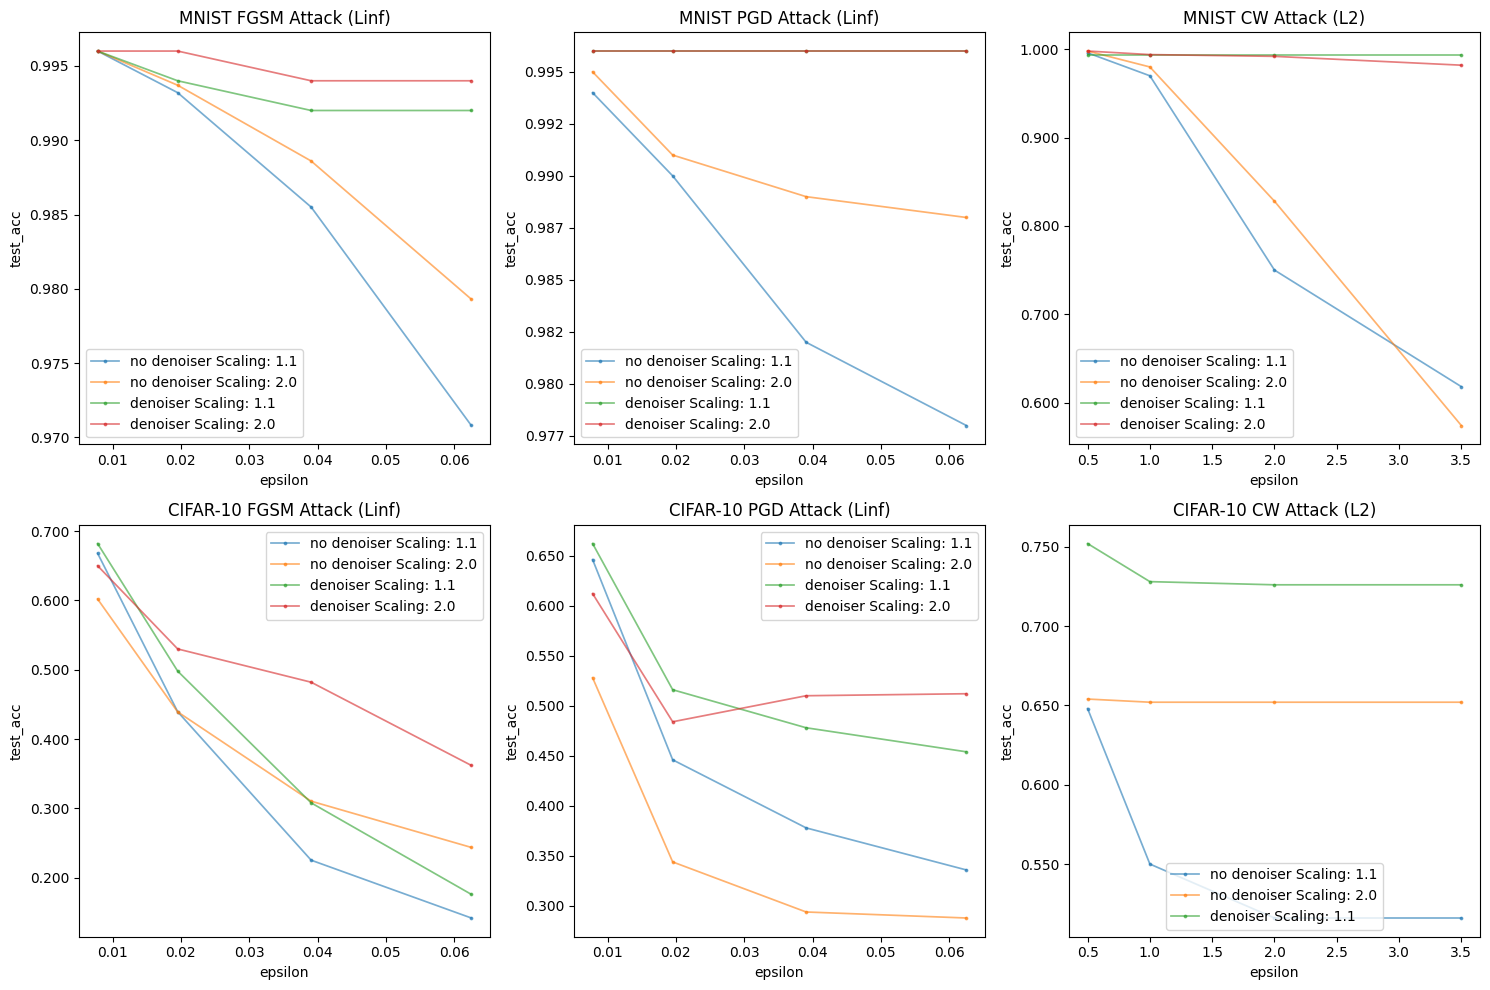

In [123]:
# comparison with denoising addition

# combine denoising and ensemble only data
df_filt = pd.concat([df, denoise_df])

# filter to (scaling, up_samplers, down_samplers) = (2.0, 3, 3), (1.1, 7, 7)
df_filt = df_filt[
    ((df_filt['scaling_factor'] == 2.0) & (df_filt['up_samplers'] == 3) & (df_filt['down_samplers'] == 3)) | \
    ((df_filt['scaling_factor'] == 1.1) & (df_filt['up_samplers'] == 7) & (df_filt['down_samplers'] == 7))
]
# filter to weighted_vote
df_filt = df_filt[
    (df_filt['voting_method'] == 'weighted_vote')
]
df_filt = drop_redundant_cols(df_filt)

# filter by attack type and dataset
plot_data = {}
for dataset in ['mnist', 'cifar10']:
    for attack_type in ['fgsm', 'pgd', 'cw']:
        df_attack = df_filt[
            (df_filt['attack_type'] == attack_type) & \
            (df_filt['dataset'] == dataset)
        ]
        df_attack = df_attack.sort_values(by=['attack_type','denoiser','scaling_factor','up_samplers', 'down_samplers', 'epsilon'])
        # df_attack = drop_redundant_cols(df_attack)

        # create arrays of test_acc and epsilon for each attack_type and voting method
        plot_data[f'{dataset}_{attack_type}'] = {}
        for i in range(len(df_attack)):
            row = df_attack.iloc[i]
            name = f'{"denoiser" if row["denoiser"] else "no denoiser"} Scaling: {row["scaling_factor"]}'
            if name not in plot_data[f'{dataset}_{attack_type}']:
                plot_data[f'{dataset}_{attack_type}'][name] = [[], []]
            plot_data[f'{dataset}_{attack_type}'][name][0].append(row['test_acc'])
            plot_data[f'{dataset}_{attack_type}'][name][1].append(row['epsilon'])

from matplotlib.ticker import FormatStrFormatter

# plot
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0,0].set_title('MNIST FGSM Attack (Linf)')
ax[0,1].set_title('MNIST PGD Attack (Linf)')
ax[0,2].set_title('MNIST CW Attack (L2)')
ax[1,0].set_title('CIFAR-10 FGSM Attack (Linf)')
ax[1,1].set_title('CIFAR-10 PGD Attack (Linf)')
ax[1,2].set_title('CIFAR-10 CW Attack (L2)')
for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('epsilon')
        ax[i,j].set_ylabel('test_acc')
        ax[i,j].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# plot test_acc vs epsilon for each scaling factor
for i in range(2):
    for j in range(3):
        for name, data in plot_data[f'{"mnist" if i == 0 else "cifar10"}_{"fgsm" if j == 0 else "pgd" if j == 1 else "cw"}'].items():
            ax[i,j].plot(data[1], data[0], label=name, marker='o',
                linewidth=1.25, markersize=1.75, alpha=0.6)
        ax[i,j].legend()

plt.savefig('graphs/denoiser_comparison.png', dpi=100, bbox_inches='tight', pad_inches=0.05)
# add padding
plt.tight_layout()
plt.show()
